# Preprocessing

Mounting to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing required packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pickle
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
from google.colab import files
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import random

In [4]:
# Reading original data
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/lastfm-dataset-1K.tar/lastfm-dataset-1K/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv',sep="\t", on_bad_lines='skip')
# Renaming the columns
data.columns =['userid', 'timestamp', 'artist_id', 'artist_name', 'track_id', 'track_name']
print(data.shape)
# Dropping rows where track id or track name is null
data['track_name'].isnull().values.any()
data=data.dropna(subset=['track_name'])
print(data.shape)
data['track_id'].isnull().values.any()
data=data.dropna(subset=['track_id'])
print(data.shape)
# resetting the index
data.reset_index(drop=True)

(19098852, 6)
(19098840, 6)
(16936134, 6)


,userid,timestamp,artist_id,artist_name,track_id,track_name
0,user_000001,2009-05-04T13:06:09Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,f7c1f8f8-b935-45ed-8fc8-7def69d92a10,The Last Emperor (Theme)
1,user_000001,2009-05-04T12:55:34Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,475d4e50-cebb-4cd0-8cd4-c3df97987962,Tibetan Dance (Version)
2,user_000001,2009-05-03T15:48:25Z,ba2f4f3b-0293-4bc8-bb94-2f73b5207343,Underworld,dc394163-2b78-4b56-94e4-658597a29ef8,"Boy, Boy, Boy (Switch Remix)"
3,user_000001,2009-05-03T15:37:56Z,ba2f4f3b-0293-4bc8-bb94-2f73b5207343,Underworld,340d9a0b-9a43-4098-b116-9f79811bd508,Crocodile (Innervisions Orchestra Mix)
4,user_000001,2009-05-03T15:14:53Z,a16e47f5-aa54-47fe-87e4-bb8af91a9fdd,Ennio Morricone,0b04407b-f517-4e00-9e6a-494795efc73e,Ninna Nanna In Blu (Raw Deal Remix)
...,...,...,...,...,...,...
16936129,user_001000,2008-01-27T22:02:35Z,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,a490cabc-1e5c-4807-86c7-740c31a50009,Please Be Patient With Me
16936130,user_001000,2008-01-27T21:56:52Z,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,3e92e447-9e1f-440d-bc00-6734469880c5,Shake It Off
16936131,user_001000,2008-01-27T21:52:36Z,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,93d044e6-1bbb-46a6-ac8e-283382a89e6f,Side With The Seeds
16936132,user_001000,2008-01-27T21:49:12Z,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,5ac4386f-6146-4389-a762-4b43f362d2c8,Sky Blue Sky


In [17]:
tracks_per_user = data.groupby('userid')['track_id'].count()

# Calculate max, min, and average
max_tracks = tracks_per_user.max()
min_tracks = tracks_per_user.min()
avg_tracks = tracks_per_user.mean()

print(f"Maximum tracks played per user: {max_tracks}")
print(f"Minimum tracks played per user: {min_tracks}")
print(f"Average tracks played per user: {avg_tracks:.2f}")


Maximum tracks played per user: 172042
Minimum tracks played per user: 2
Average tracks played per user: 17072.72


In [19]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Group data by user and calculate time period for each user
user_time_periods = data.groupby('userid')['timestamp'].apply(lambda x: x.max() - x.min())

# Calculate min, max, and average time period
min_time_period = user_time_periods.min()
max_time_period = user_time_periods.max()
avg_time_period = user_time_periods.mean()

print(f"Minimum time period per user profile: {min_time_period}")
print(f"Maximum time period per user profile: {max_time_period}")
print(f"Average time period per user profile: {avg_time_period}")


Minimum time period per user profile: 0 days 00:37:57
Maximum time period per user profile: 2291 days 20:48:03
Average time period per user profile: 860 days 00:45:05.863911280


In [23]:
track_popularity = data.groupby('track_id')['userid'].nunique()

# Find the most popular track and the number of users
most_popular_track = track_popularity.idxmax()
num_users_listened = track_popularity.max()

print(f"The most popular track is {most_popular_track} with {num_users_listened} users.")


The most popular track is 9e2ad5bc-c6f9-40d2-a36f-3122ee2072a3 with 346 users.


In [24]:
data[data['track_id']=='9e2ad5bc-c6f9-40d2-a36f-3122ee2072a3']['track_name'].tolist()[0]

'Karma Police'

In [25]:
tracks_with_one_listener = (track_popularity == 1).sum()
print(f"The number of tracks with only one listener: {tracks_with_one_listener}")

The number of tracks with only one listener: 502134


In [ ]:
# Convert object type to datetime object
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp'] = pd.to_datetime(data['timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S.%f"))
print(data.dtypes)


Unnamed: 0              int64
userid                 object
timestamp      datetime64[ns]
artist_id              object
artist_name            object
track_id               object
track_name             object
dtype: object


In [ ]:
data.shape

(16936134, 7)

Creating Sessions

In [ ]:

# Sort the data by user and timestamp to ensure sequential order
data=data.groupby(['userid']).apply(lambda x: x.sort_values(['timestamp'], ascending=True)).reset_index(drop=True)

# Function to create unique session IDs based on time difference
def create_session_ids(data, threshold_time):
    session_ids = []
    prev_user = None
    prev_timestamp = None
    session_id_counter = 0

    for index, row in data.iterrows():
        user_id = row['userid']
        timestamp = pd.to_datetime(row['timestamp'])

        if prev_user is None or user_id != prev_user or (timestamp - prev_timestamp).total_seconds() > threshold_time:
            # Start a new session for a different user or if the time difference exceeds the threshold
            session_id_counter += 1

        session_ids.append(session_id_counter)

        prev_user = user_id
        prev_timestamp = timestamp

    return session_ids

# Set the threshold time in seconds (Here, 360 seconds = 6 minutes)
threshold_time_seconds = 360





In [ ]:
# Create unique session IDs based on the time difference
data['session_id'] = create_session_ids(data, threshold_time_seconds)

In [ ]:
data.head(-100)

,userid,timestamp,artist_id,artist_name,track_id,track_name,session_id
0,user_1,2006-08-13 13:59:20,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,c4633ab1-e715-477f-8685-afa5f2058e42,The Launching Of Big Face,1
1,user_1,2006-08-13 14:03:29,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,bc2765af-208c-44c5-b3b0-cf597a646660,Zn Zero,1
2,user_1,2006-08-13 14:10:43,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,aa9c5a80-5cbe-42aa-a966-eb3cfa37d832,The Return Of Super Barrio - End Credits,2
3,user_1,2006-08-13 14:17:40,67fb65b5-6589-47f0-9371-8a40eb268dfb,Tommy Guerrero,d9b1c1da-7e47-4f97-a135-77260f2f559d,Mission Flats,3
4,user_1,2006-08-13 14:19:06,1cfbc7d1-299c-46e6-ba4c-1facb84ba435,Artful Dodger,120bb01c-03e4-465f-94a0-dce5e9fac711,What You Gonna Do?,3
...,...,...,...,...,...,...,...
16936029,user_999,2009-05-02 09:21:16,b7ffd2af-418f-4be2-bdd1-22f8b48613da,Nine Inch Nails,f68d3318-e0b8-4612-b95b-9710e6ddd322,The Day The World Went Away,3671979
16936030,user_999,2009-05-02 09:26:34,ff4308de-5b17-4869-ad77-ea41d8bf3b18,Henry Homesweet,68fa3259-dbc2-4cb4-9fe1-326bc248f856,Pocket Monster,3671979
16936031,user_999,2009-05-02 09:28:13,b7ffd2af-418f-4be2-bdd1-22f8b48613da,Nine Inch Nails,3fffc4ec-6cf0-4e4c-b1e5-5c988f07bf3e,24 Ghosts Iii,3671979
16936032,user_999,2009-05-02 09:31:17,c27f8fae-e697-4959-a791-babfd0a4ecbf,"Raz, Dwa, Trzy",6a9ab649-5de2-4adf-a798-4fdd30805e08,Czarna Inez,3671979


In [ ]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/Project/clean_data.csv',index=False)

In [ ]:
data.shape

(16936134, 7)

In [3]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/clean_data.csv', on_bad_lines='skip',index_col=False)

Creating Tagged document for Doc2Vec

In [ ]:
def create_tagged_document(data):
    tagged_data = []
    words=[]
    session_id=1
    for idx, row in data.iterrows():
      if row['session_id'] == session_id:
        words.append(row['track_id'])
      else:
        tagged_data.append(TaggedDocument(words=words, tags=[str(session_id)]))
        words=[]
        words.append(row['track_id'])
        session_id=row['session_id']
    return tagged_data

tagged_data = create_tagged_document(data)

#Save the tagged document for future use
with open('/content/drive/MyDrive/Colab Notebooks/Project/tagged_documents.pkl', 'wb') as f:
    pickle.dump(tagged_data, f)



In [ ]:
tagged_data[-1]

TaggedDocument(words=['0143a8e6-b63d-441b-aae1-44e48a633140', '6e27866c-07a1-425d-bb4f-9d9e728db344', '039f3379-3a69-4e75-a882-df1c4e1608aa', 'f68d3318-e0b8-4612-b95b-9710e6ddd322', '3fffc4ec-6cf0-4e4c-b1e5-5c988f07bf3e', '1da70975-2cbe-49e8-abc1-3fba89e26dc3', 'bcd98fd0-05f3-4fe9-b76d-a10470bdb0a7'], tags=['3671998'])

Doc2Vec implemetation

In [ ]:
# Split data into train and test sets
train_data, test_data = train_test_split(tagged_data, test_size=0.6, random_state=42)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)
with open('/content/drive/MyDrive/Colab Notebooks/Project/test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)


In [27]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Project/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [28]:
# Split test into validation and test sets
val_data, testing_data = train_test_split(test_data, test_size=0.8, random_state=42)

In [31]:
print(data.shape)
print(len(train_data))
print(len(testing_data))
print(len(val_data))

(16936134, 7)
1468799
1762560
440639


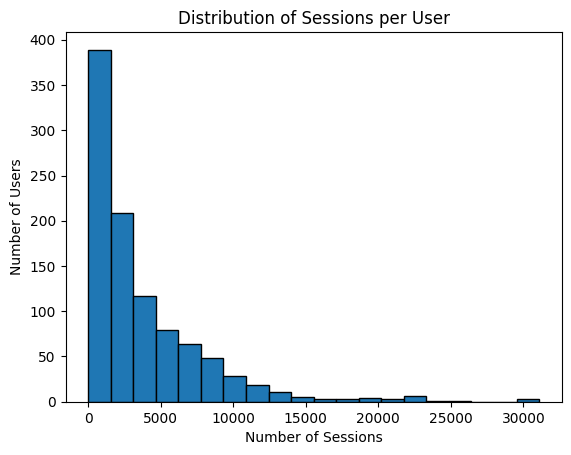

In [4]:
sessions_per_user = data.groupby('userid')['session_id'].nunique()

# Plot the distribution of sessions per user using a histogram
plt.hist(sessions_per_user, bins=20, edgecolor='black')
plt.xlabel("Number of Sessions")
plt.ylabel("Number of Users")
plt.title("Distribution of Sessions per User")
plt.show()


In [ ]:
# Training the Doc2Vec model
vector_size = 100
window = 10
epochs = 100
model = Doc2Vec(vector_size=vector_size, window=window, epochs=epochs, dm=1)
model.build_vocab(train_data)
model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)


In [ ]:
# Assuming 'model' is the trained model object that you want to save
file_path = '/content/drive/MyDrive/Colab Notebooks/Project/doc2vec_win_10_epoch_100.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(model, file)


In [ ]:
# Load the model from the downloaded file
with open('/content/drive/MyDrive/Colab Notebooks/Project/doc2vec_win_5_epoch_50.pkl', 'rb') as file:
    model1 = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/Project/doc2vec_win_10_epoch_50.pkl', 'rb') as file:
    model2 = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/Project/doc2vec_win_10_epoch_100.pkl', 'rb') as file:
    model3 = pickle.load(file)



Visualizing similar songs

In [ ]:
#song_id='8f451908-aef9-4a9b-950e-f560ba56ce7d'
song_id='49710f40-e75f-49a3-9b1f-fc7fc4894a9f'
simsongs=model1.wv.most_similar(song_id)
song_name = [data[data['track_id']==node]['track_name'].tolist()[0] for node, score in simsongs]
artist_name = [data[data['track_id']==node]['artist_name'].tolist()[0] for node, score in simsongs]
song_vector= [model1.wv[node] for node, score in simsongs]
sim_score=[score for node, score in simsongs]
#adding the actual song for vizualization
song_name.append(data[data['track_id']==song_id]['track_name'].tolist()[0])
artist_name.append(data[data['track_id']==song_id]['artist_name'].tolist()[0])
song_vector.append(model1.wv[song_id])


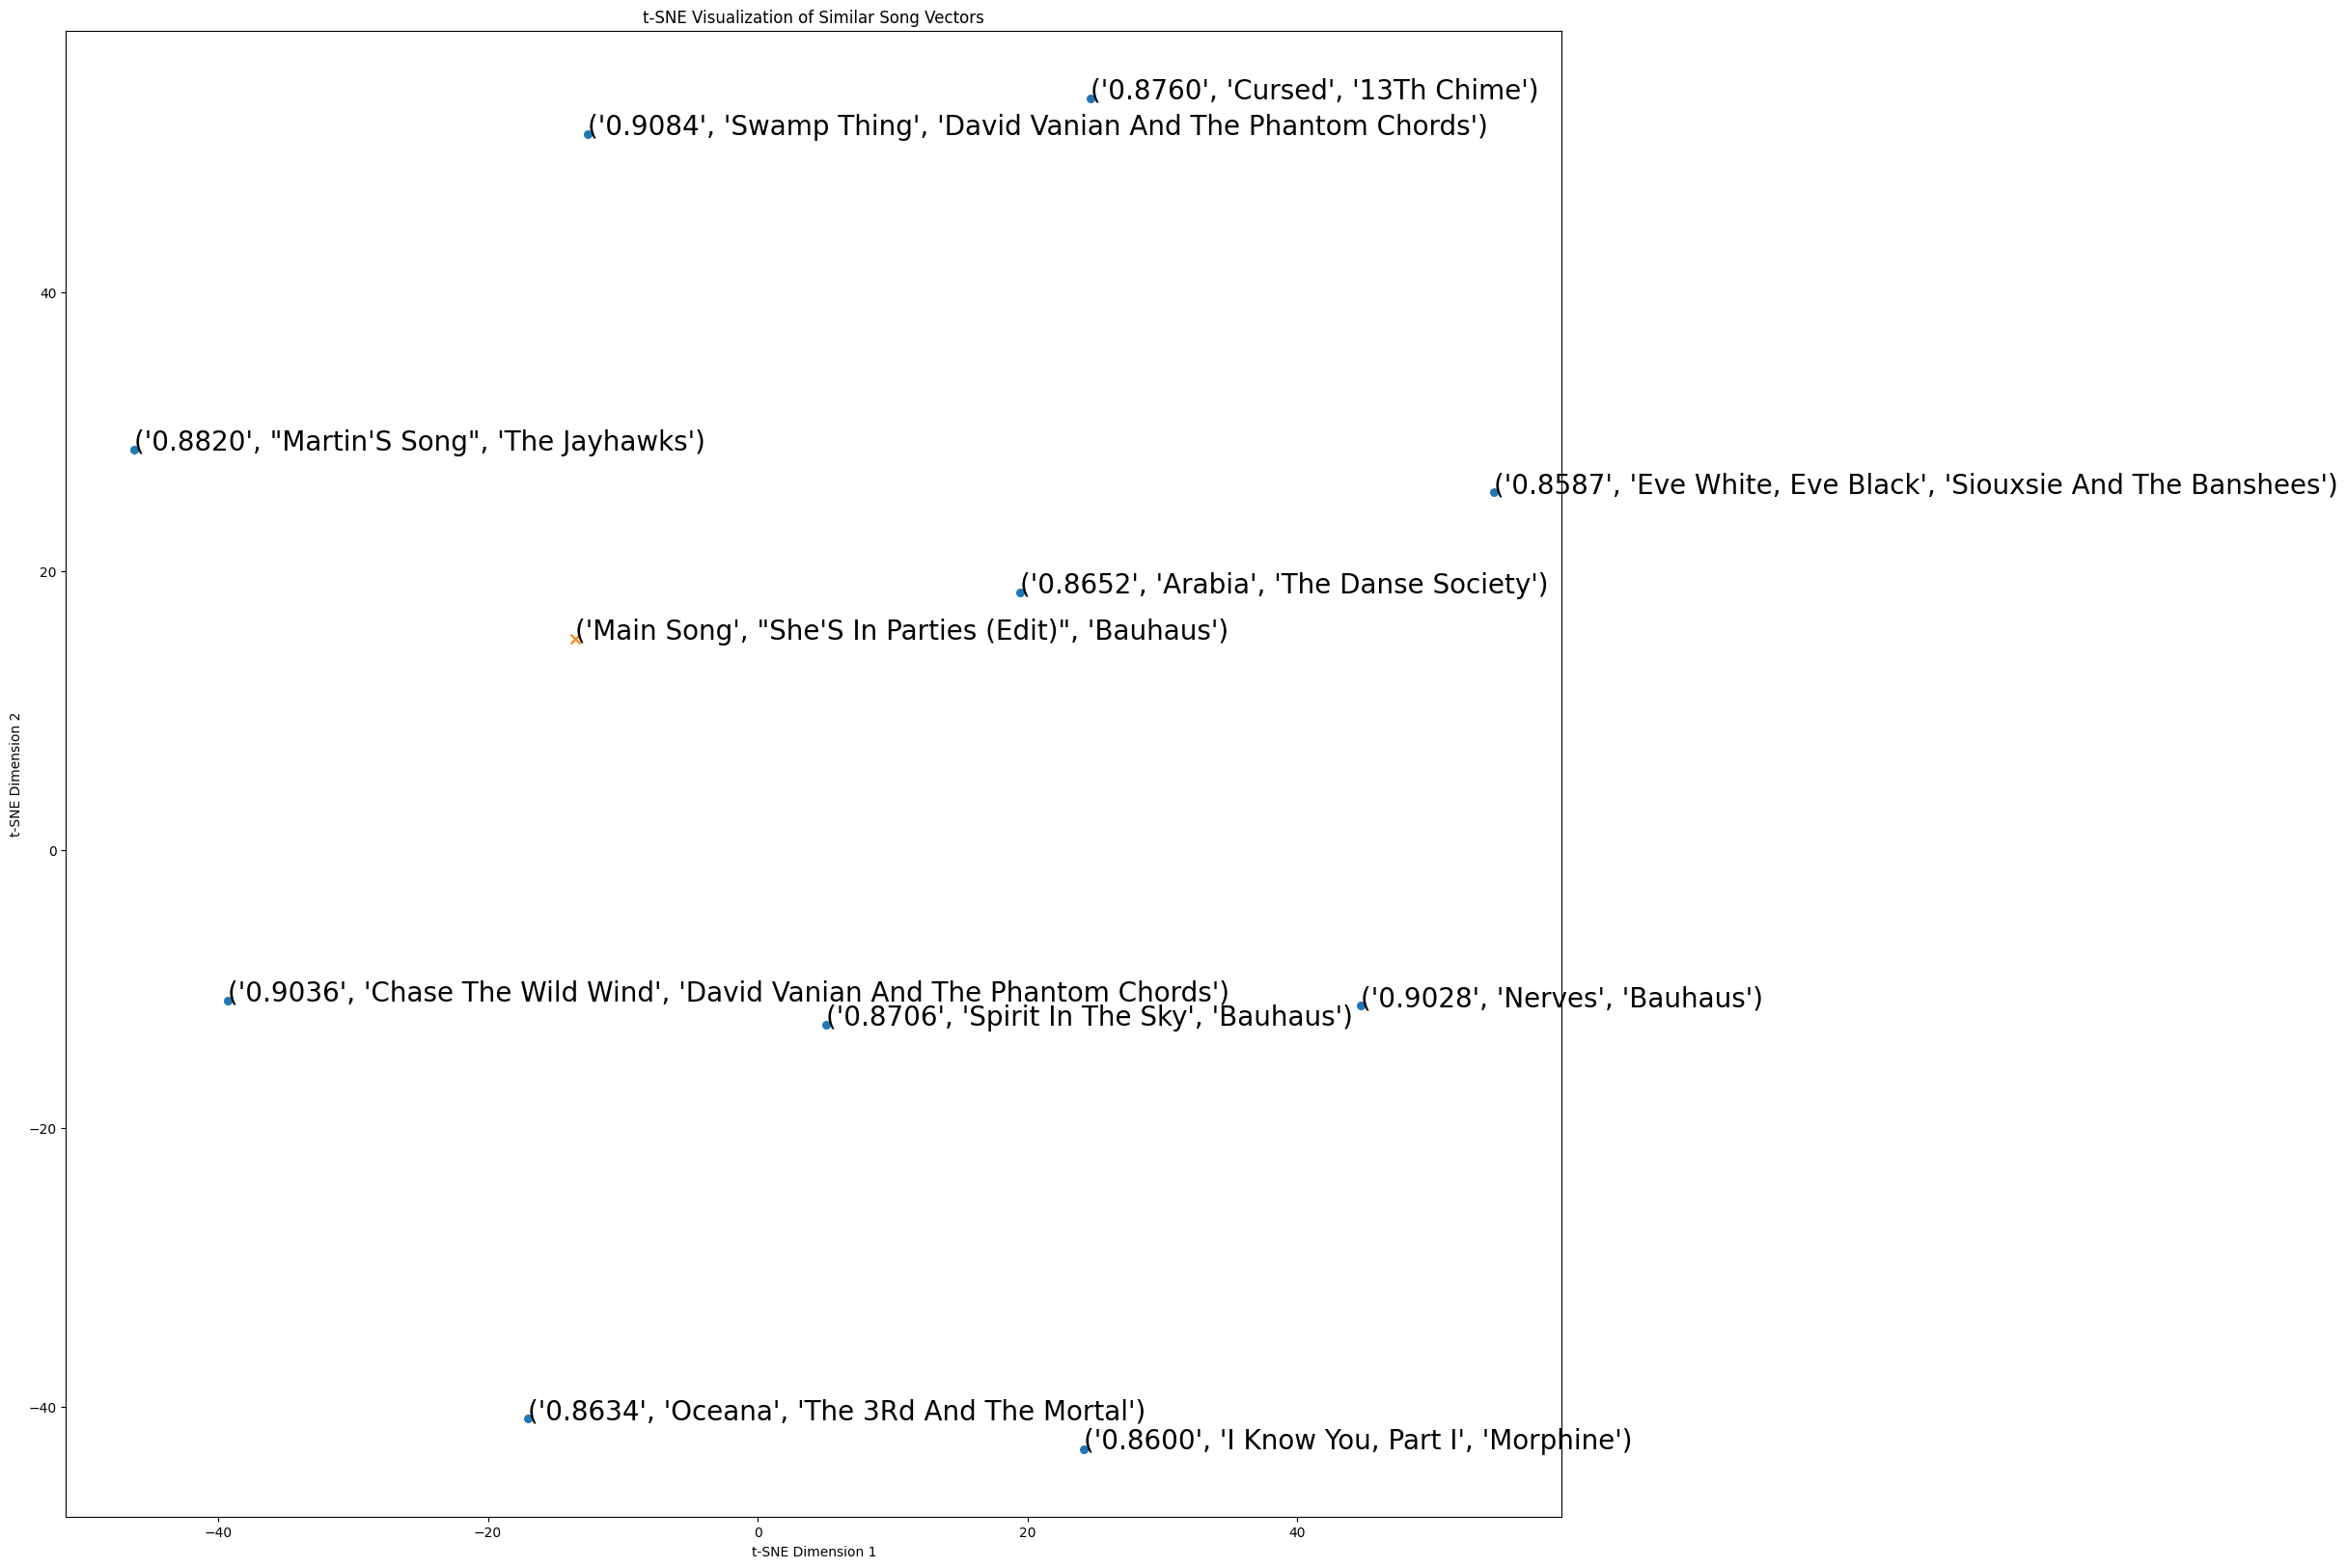

In [ ]:
# Extract song IDs and vectors
song_ids = song_name
song_vector=np.array(song_vector)

# Standardize the vectors
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(song_vector)

# Apply t-SNE for dimensionality reduction and visualization
tsne = TSNE(n_components=2, random_state=42,perplexity=10)
tsne_results = tsne.fit_transform(scaled_vectors)

# Create a scatter plot for visualization
plt.figure(figsize=(20, 20))
plt.scatter(tsne_results[:10, 0], tsne_results[:10, 1], marker='o', s=30)
plt.scatter(tsne_results[10, 0], tsne_results[10, 1], marker='x', s=50)
plt.title("t-SNE Visualization of Similar Song Vectors")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Annotate points with song IDs
for i in range(0,len(sim_score)):
    #enumerate(sim_score),song_ids):
    plt.annotate(("%.4f" % sim_score[i],song_ids[i],artist_name[i]), (tsne_results[i, 0], tsne_results[i, 1]), fontsize=20)
plt.annotate(("Main Song",song_ids[10],artist_name[10]), (tsne_results[10, 0], tsne_results[10, 1]), fontsize=20)
plt.show()


[['Saltarello', 'Song Of Sophia', 'Ullyses', 'Cantara', 'The Garden Of Zephirus', 'Enigma Of The Absolute', 'Wilderness'], ['Raw Power', 'I Need Somebody'], ['48 Hours', 'Garageland'], ['Today Your Love, Tomorrow The World', 'Havana Affair'], ['Carousel', 'Real', 'Real', 'Survive (Instrumental Mix)', 'She Wants To Be (Instrumental Mix)'], ['Severance', 'Saltarello', 'Black Sun'], ['Dominoes', 'It Is Obvious', 'Effervescing Elephant', 'Maisie'], ['Feeling Good', 'Feeling Good'], ['Thumb', 'Green Machine', 'Molten Universe', '50 Million Year Trip (Downside Up)', 'Thong Song', "Apothecaries' Weight"], ['Your Best Nightmare', 'Spider And The Fly', 'Sacrifice'], [['Love Letter', 'Love Letter', 'The Sorrowful Wife', 'The Sorrowful Wife']]]
[['Dead Can Dance', 'Dead Can Dance', 'Dead Can Dance', 'Dead Can Dance', 'Dead Can Dance', 'Dead Can Dance', 'Dead Can Dance'], ['The Stooges', 'The Stooges'], ['The Clash', 'The Clash'], ['Ramones', 'Ramones'], ['Fountain Of Tears', 'Fountain Of Tears', 

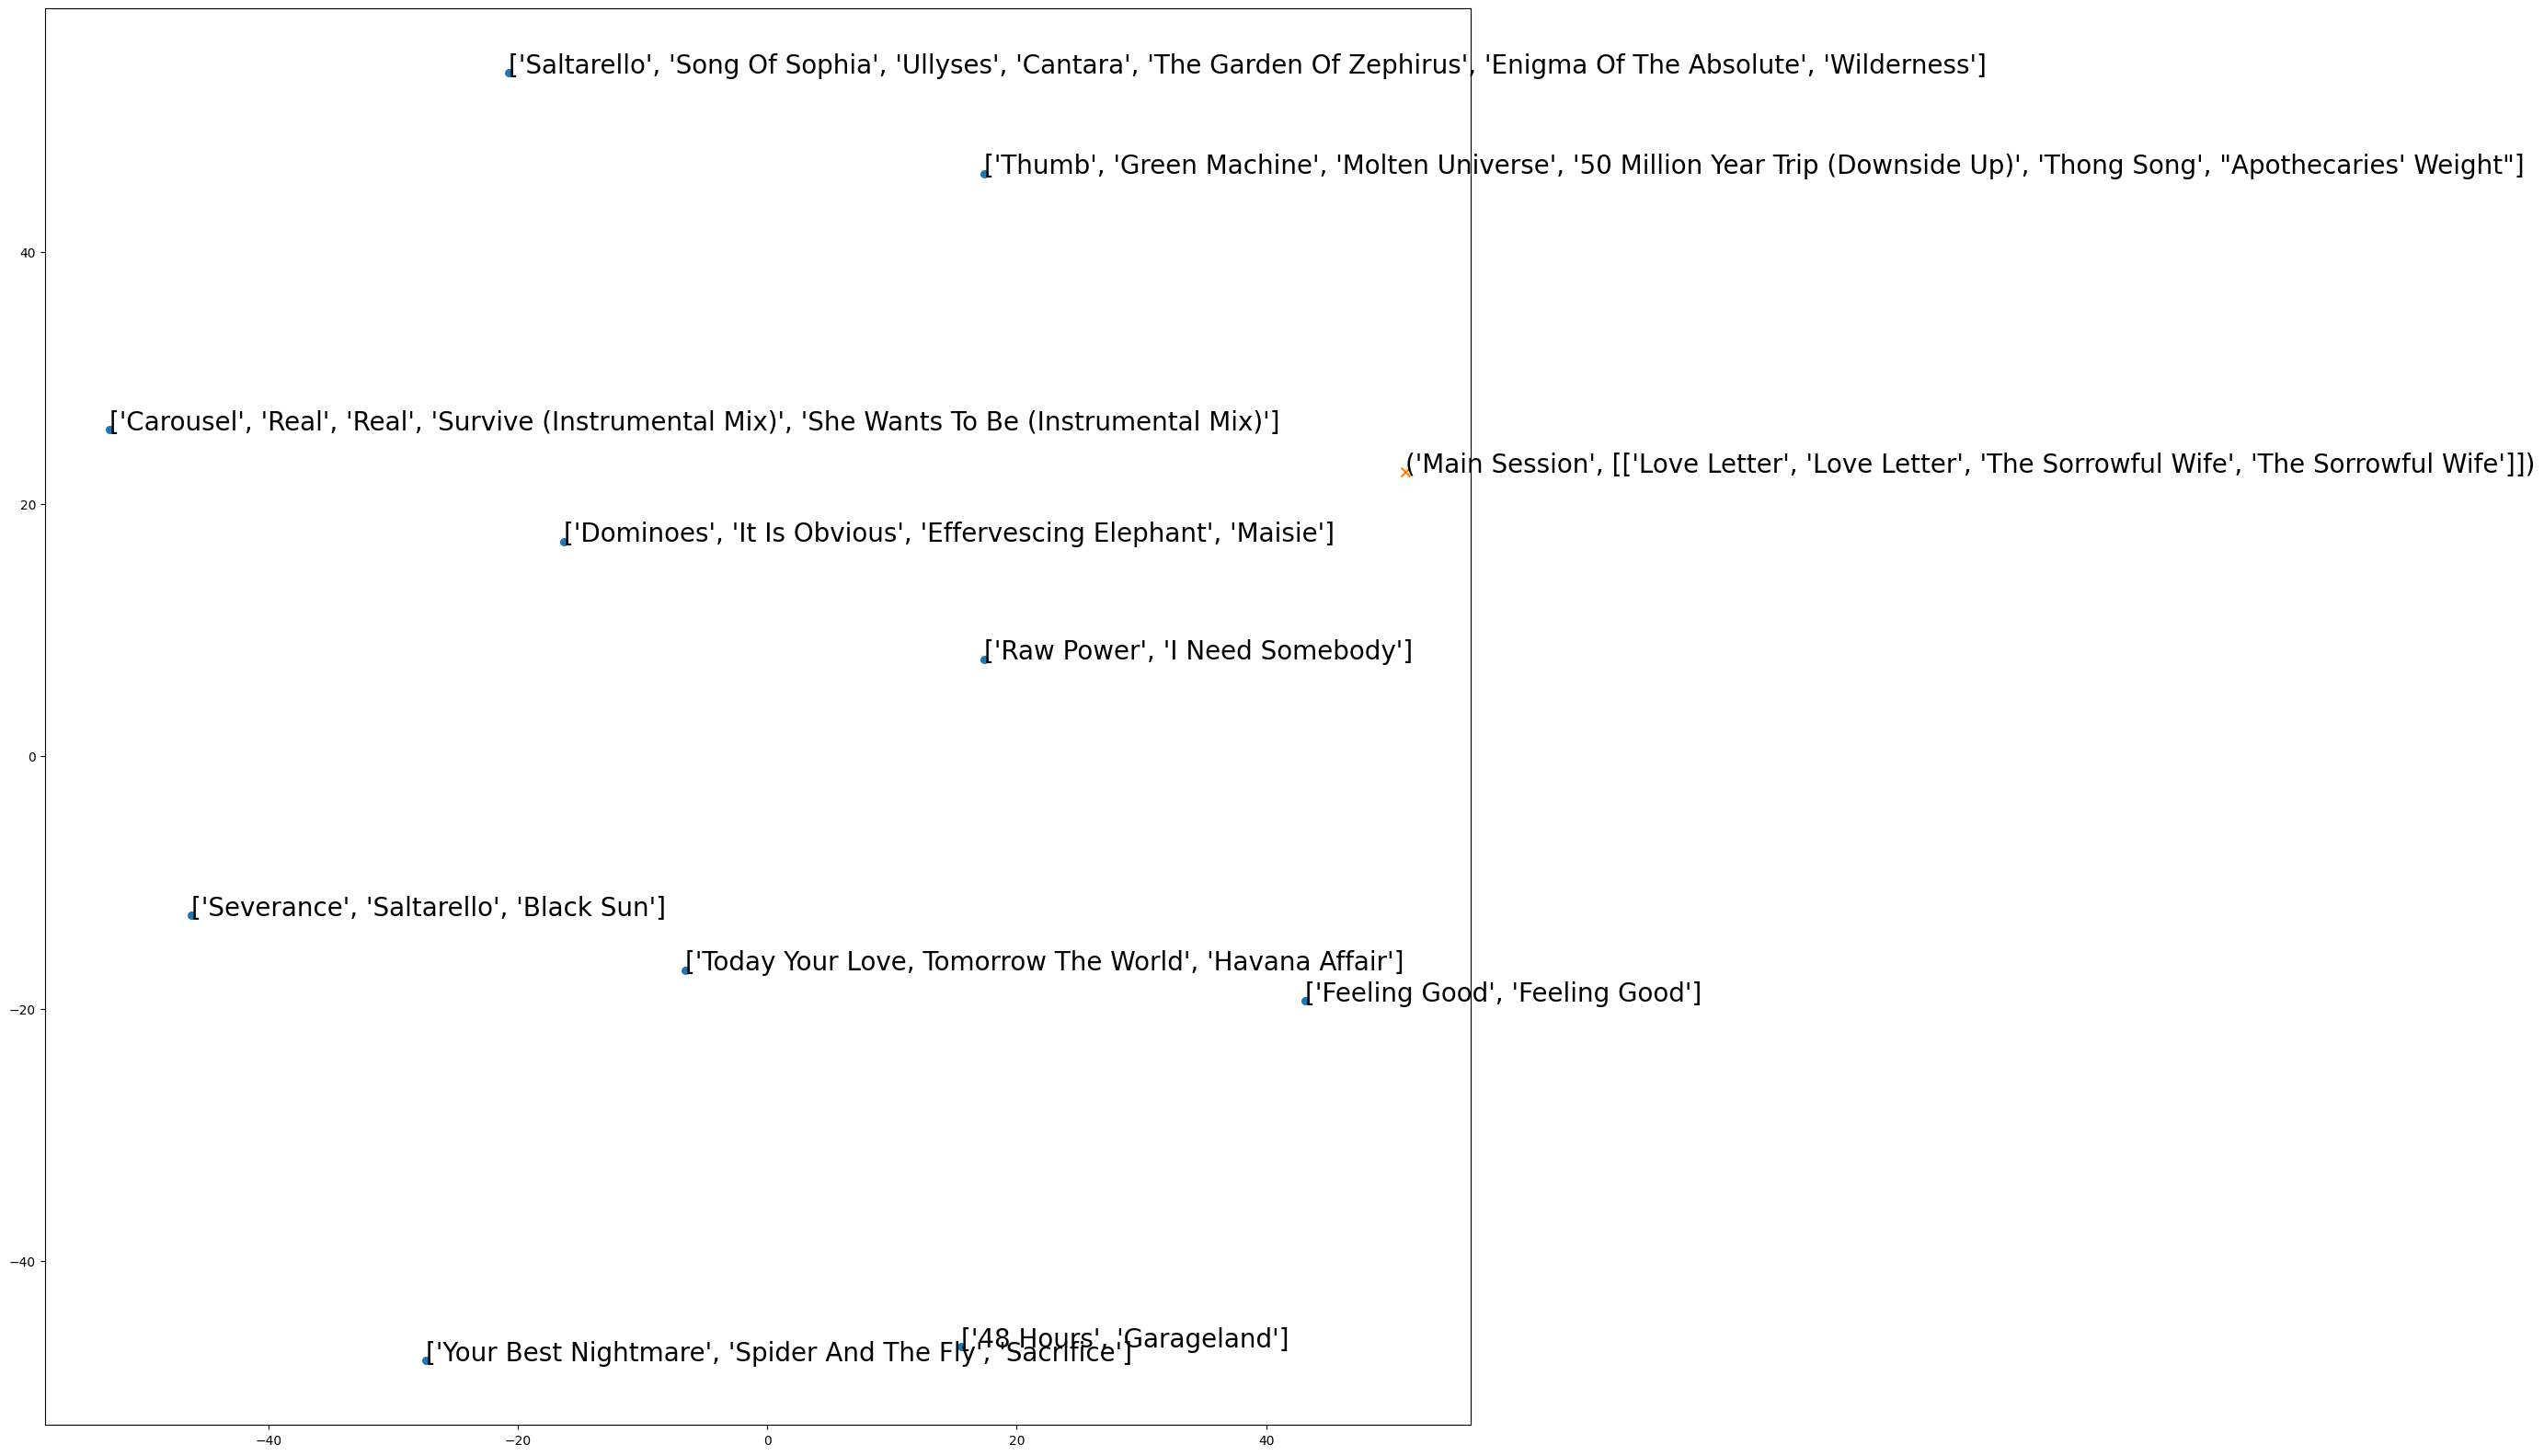

In [ ]:
#song_id='8f451908-aef9-4a9b-950e-f560ba56ce7d'
song_name=[]
artist_name=[]
session=model1.infer_vector(test_data[290002][0])
#=model.infer_vector(session)
simsession = model1.dv.most_similar([session])

for ses_id,sim_score in simsession:
    #if sim_score>=0.7:
      session_songs=data[data['session_id']==int(ses_id)]['track_name'].tolist()
      session_artists=data[data['session_id']==int(ses_id)]['artist_name'].tolist()
      song_name.append(session_songs)
      artist_name.append(session_artists)
session_vector= [model1.dv[node] for node, score in simsession]
sim_score=[score for node, score in simsession]
#adding the actual song for vizualization
song_name.append([data[data['session_id']==int(test_data[290002][1][0])]['track_name'].tolist()])
print(song_name)
artist_name.append(data[data['session_id']==int(test_data[290002][1][0])]['artist_name'].tolist()[0])
print(artist_name)
session_vector.append(session)

# Extract song IDs and vectors
song_ids = song_name
session_vector=np.array(session_vector)

# Standardize the vectors
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(session_vector)

# Apply t-SNE for dimensionality reduction and visualization
tsne = TSNE(n_components=2, random_state=42,perplexity=10)
tsne_results = tsne.fit_transform(scaled_vectors)

# Create a scatter plot for visualization
plt.figure(figsize=(20, 20))
plt.scatter(tsne_results[:10, 0], tsne_results[:10, 1], marker='o', s=30)
plt.scatter(tsne_results[10, 0], tsne_results[10, 1], marker='x', s=50)

# Annotate points with song IDs
for i in range(0,10):
    #enumerate(sim_score),song_ids):
    plt.annotate((song_ids[i]), (tsne_results[i, 0], tsne_results[i, 1]), fontsize=20)
plt.annotate(("Main Session",song_ids[10]), (tsne_results[10, 0], tsne_results[10, 1]), fontsize=20)
plt.show()




In [ ]:
def get_test_session(test_data,index):
  if len(test_data[index][0])<3:
    print("Choose some other test session as this one is too small to suggest next song.")
    return (0,0,0)
  else:
    next_song_id=test_data[index][0][-1]
    next_song=data[data['track_id']==next_song_id]['track_name'].tolist()[0]
    next_artist=data[data['track_id']==next_song_id]['artist_name'].tolist()[0]
    session=test_data[index][0][:-1]
    return session,next_song,next_artist

def recommend_top_songs(session,model):
  session_vector=model.infer_vector(session)
  simsession = model.dv.most_similar([session_vector])
  try:
    simsongs = model.wv.most_similar(session[-1],topn=5)
  except KeyError:
    simsongs = []
    pass
  recommend_songs=[]
  recommend_artist=[]
  for ses_id,sim_score in simsession:
    #if sim_score>=0.7:
      session_songs=data[data['session_id']==int(ses_id)]['track_name'].tolist()
      session_artists=data[data['session_id']==int(ses_id)]['artist_name'].tolist()
      recommend_songs.extend(session_songs)
      recommend_artist.extend(session_artists)
  # Getting uniques recommended songs in the same order
  unique_recom_songs=[]
  unique_recom_artists=[]
  for i in recommend_songs:
    if i not in unique_recom_songs:
      unique_recom_songs.append(i)
  for i in recommend_artist:
    if i not in unique_recom_artists:
      unique_recom_artists.append(i)
  if simsongs!=[]:
    songs = [data[data['track_id']==node]['track_name'].tolist()[0] for node, score in simsongs]
    artist = [data[data['track_id']==node]['artist_name'].tolist()[0] for node, score in simsongs]
    unique_recom_songs.extend(songs)
    unique_recom_artists.extend(artist)
  return unique_recom_songs,unique_recom_artists


In [ ]:
session,actual_next_song=get_test_session(test_data,290002)
recommend_top_songs(session)

['8f451908-aef9-4a9b-950e-f560ba56ce7d', '8f451908-aef9-4a9b-950e-f560ba56ce7d', 'c720e22d-2eb0-45cd-9c87-edc0f2138a36']
c720e22d-2eb0-45cd-9c87-edc0f2138a36
2822959
0.9194144010543823
['Sweetheart Come', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road']
1999797
0.9180600047111511
['Sweetheart Come', 'The Sorrowful Wife']
1474527
0.9118371605873108
['Credence', 'Karma']
2716822
0.9051225781440735
['Bad Trails', 'Prismism', 'Snare Hangar', 'Tij']
3366206
0.9043607711791992
['Sweetheart Come', 'The Sorrowful Wife']
2098373
0.903694748878479
["It'S A Long Way To The Top (If You Wanna Rock 'N' Roll)", "It'S A Long Way To The Top (If You Wanna Rock 'N' Roll)", "Rock 'N' Roll Singer"]
407050
0.9035896062850952
['Bad Trails', 'Prismism', 'Snare Hangar', 'Tij']
185080
0.9035858511924744
['Labels', '4Th Chamber', "Shadowboxin'"]
3046360
0.9035764336585999
['Washing My Hands Of It', 'Above The 60Th Parallel']
216638
0.9035269021987915
['Sweetheart Come', 'The Sorrowful Wife', '

['Sweetheart Come',
 'The Sorrowful Wife',
 'We Came Along This Road',
 'Credence',
 'Karma',
 'Bad Trails',
 'Prismism',
 'Snare Hangar',
 'Tij',
 "It'S A Long Way To The Top (If You Wanna Rock 'N' Roll)",
 "Rock 'N' Roll Singer",
 'Labels',
 '4Th Chamber',
 "Shadowboxin'",
 'Washing My Hands Of It',
 'Above The 60Th Parallel']

**Inference:** The different sessions indicate that similar sessions are found among different users too, across the whole session data, and not just one specific test user data.

In [ ]:
def hit_rate(test_data, model):
    total_sessions = len(test_data)
    correct_recommendations = 0
    actual_total_sessions=0
    for i in range(0,total_sessions):
      session,actual_next_song,actual_next_artist=get_test_session(test_data,i)
      if (session,actual_next_song,actual_next_artist)==(0,0,0):
        continue
      else:
        actual_total_sessions=actual_total_sessions+1
        recommended_songs,recommended_artist = recommend_top_songs(session,model)
        print("recommended songs",recommended_songs)
        print("actual song",actual_next_song)
        print("recommended artists",recommended_artist)
        print("actual artist",actual_next_artist)
        if actual_next_song in recommended_songs:
          correct_recommendations += 1
        elif actual_next_artist in recommended_artist:
          correct_recommendations += 0.5


    hit_rate = correct_recommendations / actual_total_sessions
    print(actual_total_sessions)
    return hit_rate

In [ ]:
hit_rate(test_data[290002:290003])

recommended songs ['The Sorrowful Wife', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road', 'Gates To The Garden', 'Darker With The Day', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road', 'Sweetheart Come', 'The Sorrowful Wife', 'Sweetheart Come', 'The Sorrowful Wife', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road', 'Gates To The Garden', 'Darker With The Day', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road', 'Sweetheart Come', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road']
actual song The Sorrowful Wife
recommended artists ['Nick Cave & The Bad Seeds', 'Nick Cave & The Bad Seeds', 'Nick Cave & The Bad Seeds', 'Nick Cave & The Bad Seeds', 'Nick Cave & The Bad Seeds', 'Nick Cave & The Bad Seeds', 'Nick Cave & The Bad Seeds', 'Nick Cave & The Bad Seeds', 'Nick 

1.0

Partial Hit Rate

In [ ]:
hit_rate(test_data[28:29])

recommended songs ['Heaven Forbid', 'Just A Girl (Radio Edit)', 'Not An Addict', 'La Marée Haute', 'Tomorrow Is A Closed Gate (Dead For So Long)', 'Starforsaken', 'Good Goodnight', 'Six Days At The Bottom Of The Ocean', 'Harder', 'Aievea', 'La Pièce Vide', "Winter'S Warning: Ii. Spring Requiem", 'Prieteni', 'Is This Love', 'Portrait Of A Deadly Nightshade', 'Glue Of The World', 'Outroduction', "New Year'S Day", 'Sweet Lilith Of My Dreams', 'New Pain', 'Cruci-Fiction In Space', 'Heaven Forbid', 'Your Name Here (Sunrise Highway)', 'Epiphany', 'Grace Kelly', 'The Day And The Time (Feat. Gustavo Cerati)', 'The Sweet Escape', 'Heaven Forbid', 'She Wolf (Live)', 'Traición A La Mejicana', 'Good Old-Fashioned Lover Boy', 'Ojos Así', 'Heaven Forbid', 'The Day And The Time (Feat. Gustavo Cerati)', 'Through With You', 'El Salmón', 'Those Crimson Tears', 'Heaven Forbid', 'Stumbling Through The Dark', 'Run', 'Better That We Break', 'She Is', 'Now Comes The Night', 'Innocence', 'Jazz Thieves', 'Anot

0.5

Session Similarity

In [ ]:
hit_rate(val_data[:15])

Choose some other test session as this one is too small to suggest next song.
recommended songs ['All Black', 'All Along The Watchtower', 'Starting Five', "I Don'T Know", 'Say This Sooner', 'Letters To God', 'Meaning In The Static', 'How Long Is The Night?', 'God', 'Screaming Infidelities', 'A Living Dance Upon Dead Minds', 'Wide Open', 'Between The Wars', 'The Busy Girl Buys Beauty', 'Mockingbird', 'A New Law', 'T-Shirts (What We Should Be Known For)', 'Which Side Are You On?', 'The Rocky Road To Dublin', 'Virus', 'It Will Stand', 'Haunt You Down', 'Tristan', 'Nazi Girlfriend', 'Causing A Commotion', 'You Belong To Me', 'Time', 'The Last In Line', 'One Slip', 'Hey Dude', 'Monday, Monday (Live At Monterey)', 'Rotterdam', 'Planet Of Sound', 'Blister In The Sun', "This Town Ain'T Big Enough For Both Of Us", 'Smalltown Boy', '9 To 5', 'The Joker', 'Right Back Where We Started From', 'Rise And Shine', 'Since You Been Gone', 'Sure Shot', 'Glitterball', 'Weirdo', 'Millionaire (Feat. André 30

0.14285714285714285

Song Similarity

In [ ]:
hit_rate(val_data[:15])

Choose some other test session as this one is too small to suggest next song.
recommended songs ['There Is No Place In This World For Me', 'Three Angels', 'Hold My Beer', 'Me And My Friends', 'I Like To Rock']
actual song The Ocean
recommended artists ['Beck', 'Headstones', 'Aaron Pritchett', 'Red Hot Chili Peppers', 'April Wine']
actual artist Ambulance Ltd
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
recommended songs ['Let Down', 'One Hot Minute', 'Broken Bottle', 'Thank You Jack White (For The Fiber-Optic Jesus That You Gave Me)', 'By The Way']
actual song Mellowship Slinky In B Major
recommended artists ["Christopher O'Riley", 'Red Hot Chili Peppers', 'Pete Yorn', 'The Flaming Lips', 'Red Hot Chili Peppers']
actual artist Red Hot Chili Peppers
recommended songs ['Apocalypso', 'Small Ambulance', 'Saviours Of Jazz Ballet (Fear Me, December)', 'So Long', 'Every Light']
actua

0.42857142857142855

Combined Similarity

In [ ]:
hit_rate(val_data[:15])

Choose some other test session as this one is too small to suggest next song.
recommended songs ['All Black', 'All Along The Watchtower', 'Starting Five', "I Don'T Know", 'Say This Sooner', 'Letters To God', 'Meaning In The Static', 'How Long Is The Night?', 'God', 'Screaming Infidelities', 'A Living Dance Upon Dead Minds', 'Wide Open', 'Between The Wars', 'The Busy Girl Buys Beauty', 'Mockingbird', 'A New Law', 'T-Shirts (What We Should Be Known For)', 'Which Side Are You On?', 'The Rocky Road To Dublin', 'Virus', 'You Belong To Me', 'Time', 'The Last In Line', 'One Slip', 'Tristan', 'Nazi Girlfriend', 'Causing A Commotion', 'Hey Dude', 'Monday, Monday (Live At Monterey)', 'Rotterdam', 'Planet Of Sound', 'Blister In The Sun', "This Town Ain'T Big Enough For Both Of Us", 'Sure Shot', 'Glitterball', 'Weirdo', 'Millionaire (Feat. André 3000)', "It'S A Long Way To The Top", 'It Will Stand', 'Haunt You Down', 'Smalltown Boy', '9 To 5', 'The Joker', 'Right Back Where We Started From', 'Rise

0.42857142857142855

MRR evaluation

Since we are trying to calculate MRR it would be better to only consider song similarity rather than song and session similarity because session similarity does not have ranking for songs but sessions.

In [ ]:
def recommend_top_songs_songsim(session,model):
  session_vector=model.infer_vector(session)
  #simsession = model.dv.most_similar([session_vector])
  try:
    simsongs = model.wv.most_similar(session[-1],topn=10)
  except KeyError:
    simsongs = []
    pass
  unique_recom_songs=[]
  unique_recom_artists=[]
  if simsongs!=[]:
    songs = [data[data['track_id']==node]['track_name'].tolist()[0] for node, score in simsongs]
    artist = [data[data['track_id']==node]['artist_name'].tolist()[0] for node, score in simsongs]
    unique_recom_songs.extend(songs)
    unique_recom_artists.extend(artist)
  return unique_recom_songs,unique_recom_artists

def MRR(test_data, model):
    total_sessions = len(test_data)
    sum_reciprocal_rank = 0
    actual_total_sessions=0
    for i in range(0,total_sessions):
      session,actual_next_song,actual_next_artist=get_test_session(test_data,i)
      if (session,actual_next_song,actual_next_artist)==(0,0,0):
        continue
      else:
        actual_total_sessions=actual_total_sessions+1
        recommended_songs,recommended_artist = recommend_top_songs_songsim(session,model)
        print("recommended songs",recommended_songs)
        print("actual song",actual_next_song)
        print("recommended artists",recommended_artist)
        print("actual artist",actual_next_artist)
        if actual_next_song in recommended_songs:
          rank = recommended_songs.index(actual_next_song)+1 #because we start from 0 index
          print(rank)
          sum_reciprocal_rank += 1.0/rank
          print(sum_reciprocal_rank)


    mrr = sum_reciprocal_rank / actual_total_sessions
    print(actual_total_sessions)
    return mrr

Hyper Parameter tuning

win_5_epoch_50


In [ ]:
hit_rate(val_data[:55],model1)

Choose some other test session as this one is too small to suggest next song.
recommended songs ["I Don'T Know", 'All Along The Watchtower', "Sunshinin'", 'All Black', 'Starting Five', 'Say This Sooner', 'Letters To God', 'Meaning In The Static', 'How Long Is The Night?', 'God', 'Screaming Infidelities', 'A Living Dance Upon Dead Minds', 'Wide Open', 'Tristan', 'Nazi Girlfriend', 'Causing A Commotion', 'Between The Wars', 'The Busy Girl Buys Beauty', 'Mockingbird', 'A New Law', 'T-Shirts (What We Should Be Known For)', 'Which Side Are You On?', 'The Rocky Road To Dublin', 'Virus', 'It Will Stand', 'Haunt You Down', 'You Belong To Me', 'Time', 'The Last In Line', 'One Slip', 'Smalltown Boy', '9 To 5', 'The Joker', 'Right Back Where We Started From', 'Rise And Shine', 'Since You Been Gone', 'Twenty Eight', 'Losing My Religion', 'Say Hello', 'Dirty Movies', 'Where Have All The Good Times Gone?', 'Oowatanite', 'Slipping Away']
actual song The Ocean
recommended artists ['Beastie Boys', 'Bob

0.3392857142857143

In [ ]:
MRR(val_data[:55],model1)

Choose some other test session as this one is too small to suggest next song.
recommended songs ['Say Hello', 'Dirty Movies', 'Where Have All The Good Times Gone?', 'Oowatanite', 'Slipping Away', 'Race With Devil On Spanish Highway', 'Just Between You And Me', 'Make Your Move', 'The Last In Line', 'Bad Side Of The Moon']
actual song The Ocean
recommended artists ['April Wine', 'Van Halen', 'Van Halen', 'April Wine', 'Black Sabbath', 'Al Di Meola', 'April Wine', 'Rainbow', 'Dio', 'April Wine']
actual artist Ambulance Ltd
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
recommended songs ['#36', 'All Along The Watchtower (Live)', 'Breaking The Girl', 'Watchtower Intro', 'Burning Bush (Everybody)', 'Material Thing', 'Tearjerker', 'Beautiful', 'Yertle The Turtle', 'Helter Skelter (Live)']
actual song Mellowship Slinky In B Major
recommended artists ['Dave Matthews Band', 'U2', 'Red Ho

0.12063492063492064

win_10_epoch_50

In [ ]:
hit_rate(val_data[:55],model2)

Choose some other test session as this one is too small to suggest next song.
recommended songs ["I Don'T Know", 'All Along The Watchtower', 'All Black', 'Starting Five', 'Say This Sooner', 'Letters To God', 'Meaning In The Static', 'How Long Is The Night?', 'God', 'Screaming Infidelities', 'A Living Dance Upon Dead Minds', 'Wide Open', 'Between The Wars', 'The Busy Girl Buys Beauty', 'Mockingbird', 'A New Law', 'T-Shirts (What We Should Be Known For)', 'Which Side Are You On?', 'The Rocky Road To Dublin', 'Virus', 'Tristan', 'Nazi Girlfriend', 'Causing A Commotion', 'It Will Stand', 'Haunt You Down', 'You Belong To Me', 'Time', 'The Last In Line', 'One Slip', 'Hey Dude', 'Monday, Monday (Live At Monterey)', 'Rotterdam', 'Planet Of Sound', 'Blister In The Sun', "This Town Ain'T Big Enough For Both Of Us", 'Blackbird', 'Blue Jeans', 'Smalltown Boy', '9 To 5', 'The Joker', 'Right Back Where We Started From', 'Rise And Shine', 'Since You Been Gone', 'There Is No Place In This World For Me

0.30357142857142855

In [ ]:
MRR(val_data[:55],model2)

Choose some other test session as this one is too small to suggest next song.
recommended songs ['There Is No Place In This World For Me', 'Three Angels', 'Hold My Beer', 'Me And My Friends', 'I Like To Rock', 'Stand Up And Shout', 'Back To Back', 'Shame On The Night', 'Where Have All The Good Times Gone?', 'Runaround']
actual song The Ocean
recommended artists ['Beck', 'Headstones', 'Aaron Pritchett', 'Red Hot Chili Peppers', 'April Wine', 'Dio', 'Deep Purple', 'Dio', 'Van Halen', 'Van Halen']
actual artist Ambulance Ltd
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
recommended songs ['Let Down', 'One Hot Minute', 'Broken Bottle', 'Thank You Jack White (For The Fiber-Optic Jesus That You Gave Me)', 'By The Way', 'My Lovely Man', 'Under The Bridge', 'Easily', 'Warm Tape', 'One Of Those Days']
actual song Mellowship Slinky In B Major
recommended artists ["Christopher O'Riley", '

0.10714285714285714

win_10_epoch_100

In [ ]:
hit_rate(val_data[:55],model3)

Choose some other test session as this one is too small to suggest next song.
recommended songs ['Where Is Home?', 'Kreuzberg', 'I Still Remember', 'Sunday', 'Srxt', 'All Along The Watchtower', 'All Black', 'Starting Five', "I Don'T Know", 'It Will Stand', 'Haunt You Down', 'Boat On The River', "Sunshinin'", 'Lucy (Version #2)', 'You Know Who I Am', 'The Land Of Plenty', 'Bring It On', 'Stories Of The Street', 'By The Rivers Dark', 'Faraway, So Close', 'Because Of', 'The Future', 'Romance In Durango', "(I Can'T Get No) Satisfaction", 'Paint It, Black', 'Start Me Up', 'Tristan', 'Nazi Girlfriend', 'Causing A Commotion', 'Drop Your Guns', 'Oowatanite', 'I Like To Rock', 'Dangerous', 'Source Of Infection']
actual song The Ocean
recommended artists ['Bloc Party', 'Bob Dylan', 'Big L', 'Dios (Malos)', 'Beastie Boys', 'Jonathan Richman & The Modern Lovers', 'Pavement', 'Styx', 'The Vines', 'Nick Cave & The Bad Seeds', 'Leonard Cohen', 'Nick Cave', 'The Rolling Stones', 'Dead Can Dance', 'Igg

0.32142857142857145

In [ ]:
MRR(val_data[:55],model3)

Choose some other test session as this one is too small to suggest next song.
recommended songs ['Drop Your Guns', 'Oowatanite', 'I Like To Rock', 'Dangerous', 'Source Of Infection', 'Rock Your Heart Out', 'At The Hundredth Meridian', 'Shame On The Night', 'Polly (Solo Acoustic, 1988)', 'Three Angels']
actual song The Ocean
recommended artists ['April Wine', 'April Wine', 'April Wine', 'Ying Yang Twins', 'Van Halen', 'Ac/Dc', 'The Tragically Hip', 'Dio', 'Nirvana', 'Headstones']
actual artist Ambulance Ltd
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
recommended songs ['One Hot Minute', 'Watchtower Intro', 'By The Way', 'Idlers Dream', 'The Ha Ha Wall', "Don'T Drink The Water", 'One Of Those Days', 'Thank You Jack White (For The Fiber-Optic Jesus That You Gave Me)', 'Breaking The Girl', 'Broken Bottle']
actual song Mellowship Slinky In B Major
recommended artists ['Red Hot Chi

0.125

Final Testing

In [ ]:
hit_rate(testing_data[:150],model1)

Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
recommended songs ['Le Disko (Boys Noize Vocal Mix)', "Quando Verra' Il Momento", 'Suitcase', 'Body Crumbles', 'Things That Scare Me', 'Sleeping Awake', 'Bullet The Blue Sky', 'Fattanza Blu', 'Prison Song', 'Heartache Every Moment', 'Make Me Bad', 'Goatless', 'Good-Bye', "You'Re All I Have", "What She Doesn'T Know", 'Your Red Nose', 'Car Underwater', 'Action/Adventure', 'Yeti', 'I Walked Through The Sky', "We'Re Looking For The Whales", 'Superstition', 'Wild Sage', 'Woke Up New', 'Vampires Will Never Hurt You', 'Edit', 'Neon Invasion', 'Saltbreakers', 'Musical Chairs', 'Un Romantico A Milano', 'Ciao Ciao', 'Il Secondo Secondo Me', 'Babbaluci', "Perché Una Ragazza D'Oggi Può Uccidersi?"]
actual song Pass The Marijuana
recommended artists ['Shiny Toy Guns', 'Colle Der Fomento', 'Joe Purdy', 'Dry Cell', 'Neko Case', 'P.O.D.', 'Sangue M

0.34868421052631576

In [ ]:
MRR(testing_data[:150],model1)

Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
recommended songs ['Un Romantico A Milano', 'Ciao Ciao', 'Il Secondo Secondo Me', 'Babbaluci', "Perché Una Ragazza D'Oggi Può Uccidersi?", 'Berta Filava', 'Preghiera', "Le Guardie, I Pompieri E L'Ambulanza", 'Rat Pack', 'La Mia Foto']
actual song Pass The Marijuana
recommended artists ['Baustelle', 'Colle Der Fomento', 'Caparezza', 'Roy Paci & Aretuska', 'Baustelle', 'Rino Gaetano', 'Tre Allegri Ragazzi Morti', 'Cor Veleno', 'Sick Of It All', 'Tre Allegri Ragazzi Morti']
actual artist Mystic Roots
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
Choose some other test session as this one is too small to suggest next song.
Choose some other test sessio

0.10339912280701755